In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

In [2]:
from tqdm import tqdm

In [3]:
# import matplotlib
# matplotlib.use('TkAgg')

In [4]:
data = pd.read_csv("data/train.csv")

In [5]:
data.head()

,TRIP_ID,CALL_TYPE,ORIGIN_CALL,ORIGIN_STAND,TAXI_ID,TIMESTAMP,DAY_TYPE,MISSING_DATA,POLYLINE
0,1372636858620000589,C,NaN,NaN,20000589,1372636858,A,False,"[[-8.618643,41.141412],[-8.618499,41.141376],[..."
1,1372637303620000596,B,NaN,7.0,20000596,1372637303,A,False,"[[-8.639847,41.159826],[-8.640351,41.159871],[..."
2,1372636951620000320,C,NaN,NaN,20000320,1372636951,A,False,"[[-8.612964,41.140359],[-8.613378,41.14035],[-..."
3,1372636854620000520,C,NaN,NaN,20000520,1372636854,A,False,"[[-8.574678,41.151951],[-8.574705,41.151942],[..."
4,1372637091620000337,C,NaN,NaN,20000337,1372637091,A,False,"[[-8.645994,41.18049],[-8.645949,41.180517],[-..."


# Exploratory Analysis

In [6]:
dims = 0
for i in data.columns:
    print(i,data[i].nunique())
    dims += data[i].nunique()

TRIP_ID 1710589
CALL_TYPE 3
ORIGIN_CALL 57105
ORIGIN_STAND 63
TAXI_ID 448
TIMESTAMP 1655366
DAY_TYPE 1
MISSING_DATA 2
POLYLINE 1703650


In [6]:
training = data[~data['MISSING_DATA']]

# adding date time, modified from given feature engineering notebook
getdate = lambda x : [tuple([i.year, i.month, i.day, i.hour, i.weekday()]) for i in [datetime.fromtimestamp(x["TIMESTAMP"])]][0]
training[["YR", "MON", "DAY", "HR", "WK"]] = training[["TIMESTAMP"]].apply(getdate, axis=1, result_type="expand")
training = training.drop(columns = ['TIMESTAMP'])

# adding trip time, using the given 15 second formula on polyline
training['TRIP_TIME'] = training['POLYLINE'].apply(lambda x : max(x.count(".")/2-1,0)*15)
training = training.drop(columns = ['POLYLINE'])

C:\Users\ishpa\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\frame.py:3641: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [8]:
training

,TRIP_ID,CALL_TYPE,ORIGIN_CALL,ORIGIN_STAND,TAXI_ID,DAY_TYPE,MISSING_DATA,YR,MON,DAY,HR,WK,TRIP_TIME
0,1372636858620000589,C,NaN,NaN,20000589,A,False,2013,6,30,17,6,330.0
1,1372637303620000596,B,NaN,7.0,20000596,A,False,2013,6,30,17,6,270.0
2,1372636951620000320,C,NaN,NaN,20000320,A,False,2013,6,30,17,6,960.0
3,1372636854620000520,C,NaN,NaN,20000520,A,False,2013,6,30,17,6,630.0
4,1372637091620000337,C,NaN,NaN,20000337,A,False,2013,6,30,17,6,420.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1710665,1404171463620000698,C,NaN,NaN,20000698,A,False,2014,6,30,16,0,465.0
1710666,1404171367620000670,C,NaN,NaN,20000670,A,False,2014,6,30,16,0,435.0
1710667,1388745716620000264,C,NaN,NaN,20000264,A,False,2014,1,3,2,4,0.0
1710668,1404141826620000248,B,NaN,12.0,20000248,A,False,2014,6,30,8,0,915.0


In [ ]:
plt.hist(training['TRIP_TIME'], bins = np.arange(0,3000,30), density = True)
plt.ylabel('Probability density')
plt.xlabel('Trip time in seconds')
plt.show()
plt.savefig("timedisthist.png")
plt.show()

In [165]:
import json
import seaborn as sns
from matplotlib.ticker import MaxNLocator

In [ ]:
paths = data[~data['MISSING_DATA']]['POLYLINE']
points = []

for path in tqdm(paths):
    points += json.loads(path)

pts = np.array(points)

In [ ]:
npts = pts[np.arange(len(pts))%20==0]

m0 = np.mean(npts[:,0])
s0 = np.std(npts[:,0])
m1 = np.mean(npts[:,1])
s1 = np.std(npts[:,1])

npts = npts[((npts[:,1] > m1-3*s1) & (npts[:,1] < m1+3*s1))&((npts[:,0] > m0-3*s0) & (npts[:,0] < m0+3*s0))]

In [ ]:
coordinates = npts

# Extract latitude and longitude from filtered coordinates
latitude = coordinates[:, 1]
longitude = coordinates[:, 0]

# Create a 2D grid for the heatmap
heatmap, xedges, yedges = np.histogram2d(latitude, longitude, bins=200, range = [[41.125,41.210],[-8.700,-8.550]])

# Create the heatmap using seaborn
ax = sns.heatmap(heatmap,xticklabels=False, yticklabels=False,vmax=7500)
ax.invert_yaxis()

# Set the x and y axis tick positions and labels

# Add title and labels
plt.title("Geographic Heatmap")
plt.xlabel("Longitude (-8.700 to -8.550)")
plt.ylabel("Latitude (41.125 to 41.210)")

# Show the plot
plt.show()
plt.savefig("heatmap.png")

## Further analysis

In [ ]:
training.head()

# Model testing and training

## Linear Model

In [7]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

In [34]:
linearfeatures = training.drop(columns = ['TRIP_ID','ORIGIN_CALL','ORIGIN_STAND','TAXI_ID','DAY_TYPE','MISSING_DATA'])
linearfeatures = np.random.permutation(linearfeatures)

train = linearfeatures[:(len(linearfeatures)*8)//10]
test = linearfeatures[(len(linearfeatures)*8)//10:]

xtrain, ytrain = train[:,:-1], train[:,-1]
xtest, ytest = test[:,:-1], test[:,-1]

In [35]:
#xtrain, ytrain
linfeat = training.drop(columns = ['TRIP_ID','ORIGIN_CALL','ORIGIN_STAND','TAXI_ID','DAY_TYPE','MISSING_DATA'])
for i in linfeat.columns:
    print(i,linfeat[i].nunique())

CALL_TYPE 3
YR 2
MON 12
DAY 31
HR 24
WK 7
TRIP_TIME 1254


In [39]:
def getlinmdl(X,y):
    grphr = Pipeline([('func',FunctionTransformer(lambda x : x//8)),('one-hot2',OneHotEncoder(handle_unknown='ignore'))])
    pret = ColumnTransformer(transformers = [("one-hot",OneHotEncoder(handle_unknown='ignore'),[0,2,5]),
                                            ('hourtrans',grphr,[4]),], 
                                 remainder = "drop")
    mdl = Pipeline([('ohe',pret),('linreg',LinearRegression())])
    mdl.fit(X,y)
    return mdl

def initialtrans(data):
    getdate = lambda x : [tuple([i.year, i.month, i.day, i.hour, i.weekday()]) for i in [datetime.fromtimestamp(x["TIMESTAMP"])]][0]
    data[["YR", "MON", "DAY", "HR", "WK"]] = data[["TIMESTAMP"]].apply(getdate, axis=1, result_type="expand")
    data = data.drop(columns = ['TIMESTAMP','TRIP_ID','ORIGIN_CALL','ORIGIN_STAND','TAXI_ID','DAY_TYPE','MISSING_DATA'])
    return data

In [102]:
linmdl = getlinmdl(xtrain, ytrain)

In [103]:
linmdl.score(xtest,ytest)

0.017059113325946895

In [104]:
linmdl.score(xtrain,ytrain)

0.01679197385402742

In [105]:
linmdl.predict([xtest[6]])

array([634.79026855])

In [ ]:
finallinmdl = getlinmdl(linearfeatures[:,:-1],linearfeatures[:,-1])

In [ ]:
true_test = pd.read_csv('data/test_public.csv')
ttX = np.array(initialtrans(true_test))

In [ ]:
predictions = linmdl.predict(ttX)
linmdlprediction = pd.read_csv("data/sampleSubmission.csv")
linmdlprediction['TRAVEL_TIME'] = predictions
linmdlprediction.to_csv("linpred.csv", index=None)

The score given by the leaderboard was 777.83934

### Training visualization using sgd

In [116]:
def loss(X, Y, w):
    return np.sum((Y-X@w)**2)

def gradient(X, Y, w):
    return -2*np.dot((Y-np.dot(X,w)),X)

def SGD(X, Y, w_start, eta, N_epochs):
    Xmod = np.concatenate((X, np.ones((X.shape[0], 1))), axis = 1)
    w = w_start
    weights = []
    losses = np.array([])
    
    losses = np.append(losses,loss(Xmod,Y,w))
    
    for i in tqdm(range(N_epochs)):
        w = w - eta*gradient(Xmod,Y,w)
        losses = np.append(losses,loss(Xmod,Y,w))
        weights += [w]
    
    return w, losses #weights, losses *changed to only return last*

In [79]:
def lineartransform(X):
    grphr = Pipeline([('func',FunctionTransformer(lambda x : x//8)),('one-hot2',OneHotEncoder(handle_unknown='ignore'))])
    pret = ColumnTransformer(transformers = [("one-hot",OneHotEncoder(handle_unknown='ignore'),[0,2,5]),
                                            ('hourtrans',grphr,[4]),], 
                                 remainder = "drop")
    pret.fit(X)
    return pret.transform(X)

In [ ]:
x_mat = lineartransform(xtrain).todense()

In [130]:
training

,TRIP_ID,CALL_TYPE,ORIGIN_CALL,ORIGIN_STAND,TAXI_ID,DAY_TYPE,MISSING_DATA,YR,MON,DAY,HR,WK,TRIP_TIME
0,1372636858620000589,C,NaN,NaN,20000589,A,False,2013,6,30,17,6,330.0
1,1372637303620000596,B,NaN,7.0,20000596,A,False,2013,6,30,17,6,270.0
2,1372636951620000320,C,NaN,NaN,20000320,A,False,2013,6,30,17,6,960.0
3,1372636854620000520,C,NaN,NaN,20000520,A,False,2013,6,30,17,6,630.0
4,1372637091620000337,C,NaN,NaN,20000337,A,False,2013,6,30,17,6,420.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1710665,1404171463620000698,C,NaN,NaN,20000698,A,False,2014,6,30,16,0,465.0
1710666,1404171367620000670,C,NaN,NaN,20000670,A,False,2014,6,30,16,0,435.0
1710667,1388745716620000264,C,NaN,NaN,20000264,A,False,2014,1,3,2,4,0.0
1710668,1404141826620000248,B,NaN,12.0,20000248,A,False,2014,6,30,8,0,915.0


In [87]:
w,losses = SGD(np.array(x_mat), ytrain, np.zeros(26), np.exp(-15), 10)

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:56<00:00,  5.70s/it]


Text(0.5, 1.0, 'SGD Optimization')

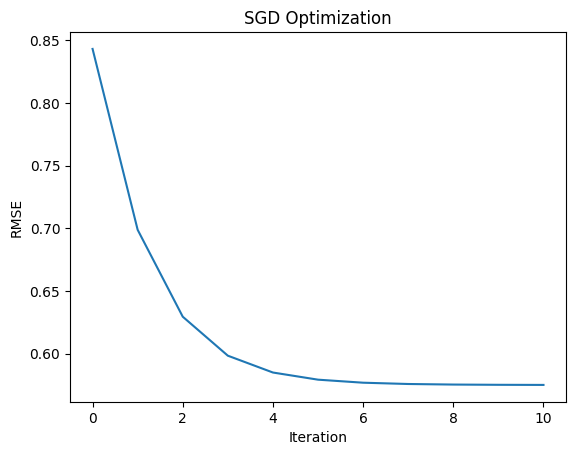

In [114]:
plt.plot(np.sqrt(losses)/x_mat.shape[0])
plt.xlabel('Iteration')
plt.ylabel('RMSE')
plt.title('SGD Optimization')

In [137]:
top10 = training.drop(columns = ['TRIP_ID','ORIGIN_CALL','ORIGIN_STAND','TAXI_ID','DAY_TYPE','MISSING_DATA'])

top10features = np.array(top10features)

top10['PRED'] = linmdl.predict(top10features)

In [167]:
top10['LOSS'] = abs(top10['TRIP_TIME'] - top10['PRED'])

top10idx = list(top10.sort_values('LOSS').index[:10])

pathlist = list(data.iloc[top10idx,:]['POLYLINE'])

paths = []

for path in pathlist:
    paths += [json.loads(path)]

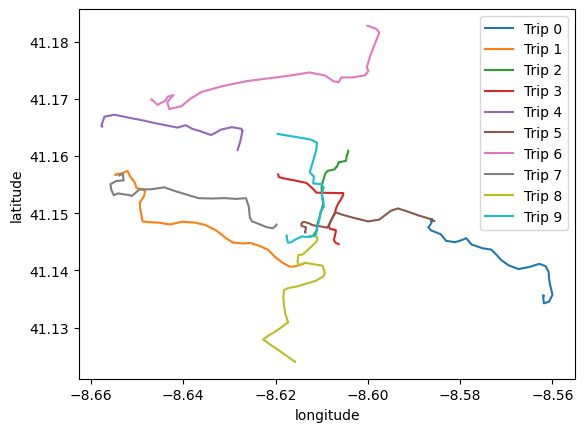

In [172]:
for i, path in enumerate(paths):
    a = np.array(path).T
    plt.plot(a[0],a[1],label=f'Trip {i}')

plt.xlabel('longitude')
plt.ylabel('latitude')
plt.legend()

plt.show()

In [162]:
top10idx

[648131,
 584632,
 584568,
 647881,
 647942,
 584408,
 584282,
 647981,
 617949,
 648286]

## MLP Model

In [8]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
from torch import cuda
import gc

In [ ]:
def clear():
    gc.collect()
    cuda.empty_cache()

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [24]:
mlpfeatures = training.drop(columns = ['TRIP_ID','ORIGIN_CALL'])
mlpfeatures = mlpfeatures.sample(frac=1)

# for i in mlpfeatures.columns:
#     print(i,mlpfeatures[i].nunique())
mean, std =  np.mean(mlpfeatures['TRIP_TIME']), np.std(mlpfeatures['TRIP_TIME'])
xtrain, ytrain = mlpfeatures.iloc[:mlpfeatures.shape[0]*8//10,:-1], mlpfeatures.iloc[:mlpfeatures.shape[0]*8//10,-1]
ytrain = (ytrain-mean)/std
xtest, ytest = mlpfeatures.iloc[mlpfeatures.shape[0]*8//10:,:-1], mlpfeatures.iloc[mlpfeatures.shape[0]*8//10:,-1]
ytest = (ytest-mean)/std

In [70]:
def mlptrans(data):
    grphr = Pipeline([('func',FunctionTransformer(lambda x : x//6)),('one-hot',OneHotEncoder(handle_unknown='ignore'))])
    pret = ColumnTransformer(transformers = [("one-hot",OneHotEncoder(handle_unknown='ignore'),
                                              ['WK','MON','TAXI_ID']), #'YR','DAY','CALL_TYPE','ORIGIN_STAND',
                                            ('hourtrans',grphr,['HR']),],
                                 remainder = "drop")
    pret.fit(mlpfeatures.drop(columns = ['TRIP_TIME']))
    return pret.transform(data).todense()

In [71]:
xtrain_mat = mlptrans(xtrain)
xtest_mat = mlptrans(xtest)

In [72]:
test_data = torch.tensor(xtest_mat, dtype=torch.float32)#.to(device)
test_target = torch.tensor(np.array(ytest), dtype=torch.float32)#.to(device)
data = torch.tensor(xtrain_mat, dtype=torch.float32)#.to(device)
target = torch.tensor(np.array(ytrain), dtype=torch.float32)#.to(device)

In [134]:
def train(mdl, epochs, data=data, targets=target):
    print(f'training')
    
    batch_size = 128
    
    mdl.train()
    criterion = nn.MSELoss() #nn.CrossEntropyLoss()
    optimizer = optim.Adam(mdl.parameters(), lr = 0.001)
    acc = []
    losses = []
    
    for epoch in range(epochs):
        
        rnls = 0
        nbat = 0
        
        for i in tqdm(range(0, data.shape[0], batch_size)):
            inputs = data[i:i+batch_size]
            target = targets[i:i+batch_size]
            
            optimizer.zero_grad()

            outputs = mdl(inputs)
            
            loss = criterion(outputs, target)
            
            loss.backward()
            optimizer.step()
            
            losses += [loss.item()]
            rnls += loss.item()
            nbat += 1
            
        print(f'Completed Epoch {epoch+1}')
        print(f'Training Loss: {rnls/nbat}')
        print(f'Test Loss : {test(mdl)}')
    
    return losses
    
def test(mdl, data=test_data, targets=test_target):
    print(f'Testing')
    
    batch_size = 128
    
    mdl.eval()
    
    sqrdloss = 0
    with torch.no_grad():
        for i in tqdm(range(0, data.shape[0], batch_size)):
            inputs = data[i:i+batch_size]
            target = targets[i:i+batch_size]
            
            output = mdl(inputs).squeeze(dim = 1)
            sqrdloss += torch.sum((target-output)**2)
            
    return sqrdloss/data.shape[0]

In [93]:
def createmlp():
    return nn.Sequential(
        nn.Linear(471, 512),
        nn.ReLU(),
        nn.Linear(512, 64),
        nn.ReLU(),
        nn.Linear(64, 1),
    )

In [94]:
newmlp = createmlp()

In [95]:
train(newmlp, 10)

training


100%|███████████████████████████████████████████████████████████████████████████| 10692/10692 [00:43<00:00, 244.09it/s]


Completed Epoch 1
Training Loss: 0.9946831235299051
Testing


100%|████████████████████████████████████████████████████████████████████████████| 2673/2673 [00:01<00:00, 2324.33it/s]


Test Loss : 1.0217899084091187


100%|███████████████████████████████████████████████████████████████████████████| 10692/10692 [00:53<00:00, 201.04it/s]


Completed Epoch 2
Training Loss: 0.9946555786303064
Testing


100%|████████████████████████████████████████████████████████████████████████████| 2673/2673 [00:01<00:00, 2420.25it/s]


Test Loss : 1.0216854810714722


100%|███████████████████████████████████████████████████████████████████████████| 10692/10692 [00:54<00:00, 197.03it/s]


Completed Epoch 3
Training Loss: 0.9946535669052552
Testing


100%|████████████████████████████████████████████████████████████████████████████| 2673/2673 [00:01<00:00, 2410.62it/s]


Test Loss : 1.0216859579086304


100%|███████████████████████████████████████████████████████████████████████████| 10692/10692 [00:55<00:00, 193.80it/s]


Completed Epoch 4
Training Loss: 0.9946527648083043
Testing


100%|████████████████████████████████████████████████████████████████████████████| 2673/2673 [00:01<00:00, 2303.71it/s]


Test Loss : 1.0216116905212402


100%|███████████████████████████████████████████████████████████████████████████| 10692/10692 [00:59<00:00, 180.61it/s]


Completed Epoch 5
Training Loss: 0.9946522575486388
Testing


100%|████████████████████████████████████████████████████████████████████████████| 2673/2673 [00:01<00:00, 2341.24it/s]


Test Loss : 1.0216768980026245


100%|███████████████████████████████████████████████████████████████████████████| 10692/10692 [01:01<00:00, 173.08it/s]


Completed Epoch 6
Training Loss: 0.9946516421203684
Testing


100%|████████████████████████████████████████████████████████████████████████████| 2673/2673 [00:01<00:00, 2306.77it/s]


Test Loss : 1.0216481685638428


100%|███████████████████████████████████████████████████████████████████████████| 10692/10692 [01:07<00:00, 158.11it/s]


Completed Epoch 7
Training Loss: 0.9946507632361674
Testing


100%|████████████████████████████████████████████████████████████████████████████| 2673/2673 [00:01<00:00, 2343.62it/s]


Test Loss : 1.0216479301452637


100%|███████████████████████████████████████████████████████████████████████████| 10692/10692 [01:08<00:00, 157.11it/s]


Completed Epoch 8
Training Loss: 0.9946501187916066
Testing


100%|████████████████████████████████████████████████████████████████████████████| 2673/2673 [00:01<00:00, 2345.43it/s]


Test Loss : 1.0216538906097412


100%|███████████████████████████████████████████████████████████████████████████| 10692/10692 [01:08<00:00, 156.35it/s]


Completed Epoch 9
Training Loss: 0.994648070102143
Testing


100%|████████████████████████████████████████████████████████████████████████████| 2673/2673 [00:01<00:00, 2354.98it/s]


Test Loss : 1.0217102766036987


100%|███████████████████████████████████████████████████████████████████████████| 10692/10692 [01:08<00:00, 155.33it/s]


Completed Epoch 10
Training Loss: 0.9946467435559528
Testing


100%|████████████████████████████████████████████████████████████████████████████| 2673/2673 [00:01<00:00, 2389.78it/s]

Test Loss : 1.0216542482376099


In [136]:
def createmlp2():
    return nn.Sequential(
        nn.Linear(471, 512),
        nn.Sigmoid(),
        nn.Linear(512, 256),
        nn.Sigmoid(),
        nn.Linear(256, 128),
        nn.Sigmoid(),
        nn.Linear(128, 64),
        nn.Sigmoid(),
        nn.Linear(64, 32),
        nn.Sigmoid(),
        nn.Linear(32, 1),
    )

In [97]:
mlpmdl2 = createmlp2()

In [98]:
train(newmlp, 5)

training


100%|███████████████████████████████████████████████████████████████████████████| 10692/10692 [00:27<00:00, 382.14it/s]


Completed Epoch 1
Training Loss: 0.9946455570238162
Testing


100%|████████████████████████████████████████████████████████████████████████████| 2673/2673 [00:01<00:00, 2259.60it/s]


Test Loss : 1.0217047929763794


100%|███████████████████████████████████████████████████████████████████████████| 10692/10692 [00:30<00:00, 350.29it/s]


Completed Epoch 2
Training Loss: 0.9946439873721218
Testing


100%|████████████████████████████████████████████████████████████████████████████| 2673/2673 [00:01<00:00, 2290.72it/s]


Test Loss : 1.0216648578643799


100%|███████████████████████████████████████████████████████████████████████████| 10692/10692 [00:31<00:00, 343.27it/s]


Completed Epoch 3
Training Loss: 0.9946436974168761
Testing


100%|████████████████████████████████████████████████████████████████████████████| 2673/2673 [00:01<00:00, 2279.77it/s]


Test Loss : 1.0216909646987915


100%|███████████████████████████████████████████████████████████████████████████| 10692/10692 [00:32<00:00, 332.11it/s]


Completed Epoch 4
Training Loss: 0.9946429419801269
Testing


100%|████████████████████████████████████████████████████████████████████████████| 2673/2673 [00:01<00:00, 2313.70it/s]


Test Loss : 1.0216792821884155


100%|███████████████████████████████████████████████████████████████████████████| 10692/10692 [00:32<00:00, 327.69it/s]


Completed Epoch 5
Training Loss: 0.9946417190912196
Testing


100%|████████████████████████████████████████████████████████████████████████████| 2673/2673 [00:01<00:00, 2349.02it/s]

Test Loss : 1.0217034816741943


In [99]:
true_test = pd.read_csv('data/test_public.csv')

In [119]:
def initialtrans2(data):
    getdate = lambda x : [tuple([i.year, i.month, i.day, i.hour, i.weekday()]) for i in [datetime.fromtimestamp(x["TIMESTAMP"])]][0]
    data[["YR", "MON", "DAY", "HR", "WK"]] = data[["TIMESTAMP"]].apply(getdate, axis=1, result_type="expand")
    return data.drop(columns = ['TRIP_ID','TIMESTAMP','ORIGIN_CALL'])

In [122]:
tt2 = torch.tensor(mlptrans(initialtrans2(true_test)), dtype=torch.float32)

In [ ]:
predictions = (mlpmdl2(tt2)*std+mean).detach().numpy() 
mlpprediction = pd.read_csv("data/sampleSubmission.csv")
mlpprediction['TRAVEL_TIME'] = predictions
mlpprediction.to_csv("mlppred.csv", index=None)

scored very bad 792.14825, worse than linear regression

In [137]:
mlpmdl3 = createmlp2()

In [138]:
batchlosses = train(mlpmdl3,2)

training


100%|███████████████████████████████████████████████████████████████████████████| 10692/10692 [00:49<00:00, 215.49it/s]


Completed Epoch 1
Training Loss: 0.9955143120559333
Testing


100%|█████████████████████████████████████████████████████████████████████████████| 2673/2673 [00:03<00:00, 739.60it/s]


Test Loss : 1.024229645729065


100%|███████████████████████████████████████████████████████████████████████████| 10692/10692 [00:51<00:00, 208.46it/s]


Completed Epoch 2
Training Loss: 0.9949295388745807
Testing


100%|█████████████████████████████████████████████████████████████████████████████| 2673/2673 [00:03<00:00, 719.34it/s]

Test Loss : 1.0220836400985718


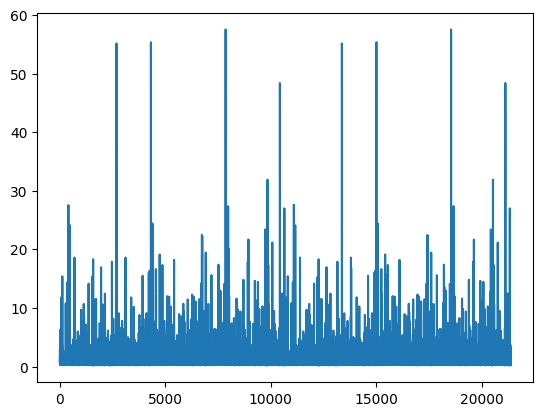

In [143]:
plt.plot(batchlosses)

## K-nearest neighbors

In [12]:
from sklearn.neighbors import KNeighborsRegressor

In [9]:
training

,TRIP_ID,CALL_TYPE,ORIGIN_CALL,ORIGIN_STAND,TAXI_ID,DAY_TYPE,MISSING_DATA,YR,MON,DAY,HR,WK,TRIP_TIME
0,1372636858620000589,C,NaN,NaN,20000589,A,False,2013,6,30,17,6,330.0
1,1372637303620000596,B,NaN,7.0,20000596,A,False,2013,6,30,17,6,270.0
2,1372636951620000320,C,NaN,NaN,20000320,A,False,2013,6,30,17,6,960.0
3,1372636854620000520,C,NaN,NaN,20000520,A,False,2013,6,30,17,6,630.0
4,1372637091620000337,C,NaN,NaN,20000337,A,False,2013,6,30,17,6,420.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1710665,1404171463620000698,C,NaN,NaN,20000698,A,False,2014,6,30,16,0,465.0
1710666,1404171367620000670,C,NaN,NaN,20000670,A,False,2014,6,30,16,0,435.0
1710667,1388745716620000264,C,NaN,NaN,20000264,A,False,2014,1,3,2,4,0.0
1710668,1404141826620000248,B,NaN,12.0,20000248,A,False,2014,6,30,8,0,915.0


In [8]:
def knntrans(data, test=pd.DataFrame(), w = [5,3,2.5,7,10,5]):
    data = pd.concat([data,test])
    data = data.drop(columns = ['TRIP_ID','DAY_TYPE','MISSING_DATA','DAY','YR'])
    
    ones = pd.get_dummies(data['CALL_TYPE'])*w[0]
    ones = ones.join(pd.get_dummies(data['ORIGIN_STAND'])*w[1])
    ones = ones.join(pd.get_dummies(data['TAXI_ID'])*w[2])
    ones = ones.join(pd.get_dummies(((pd.get_dummies(data['WK'])*w[3])).rename(columns = {0:'d0',1:'d1',2:'d2',3:'d3',4:'d4',5:'d5',6:'d6'})))
    ones['MON'] = np.abs(data['MON']-6)/6*w[4]
    ones['HR'] = np.abs(data['HR']-12)/12*w[5]
    
    return ones.iloc[:-test.shape[0],:],ones.iloc[-test.shape[0]:,:]#.to_numpy()
    

In [9]:
#knnperm = training.sample(frac=1)

xtrain, ytrain = knnperm.iloc[:knnperm.shape[0]*8//10,:-1], knnperm.iloc[:knnperm.shape[0]*8//10,-1]
xtest, ytest = knnperm.iloc[knnperm.shape[0]*8//10:,:-1], knnperm.iloc[knnperm.shape[0]*8//10:,-1]

In [10]:
knnxtrain,knnxtest = knntrans(xtrain,xtest)

In [29]:
knn = KNeighborsRegressor(n_neighbors=15, algorithm = 'brute', p = 2, weights= 'distance')
knn.fit(knnxtrain, np.array(ytrain))

KNeighborsRegressor(algorithm='brute', n_neighbors=15, weights='distance')

In [30]:
bs = []
c=0
for i in range(c,c+50):
    a,b = ytrain.iloc[i],knn.predict([knnxtest.iloc[i]])
    bs += [b[0]]
    print(a,b,abs(a-b))

1245.0 [157.50069031] [1087.49930969]
240.0 [630.] [390.]
825.0 [493.70769678] [331.29230322]
780.0 [898.0386625] [118.0386625]
2460.0 [800.] [1660.]
240.0 [923.08099147] [683.08099147]
75.0 [685.] [610.]
555.0 [515.] [40.]
330.0 [270.] [60.]
1020.0 [723.75] [296.25]
690.0 [681.59024222] [8.40975778]
360.0 [528.90313586] [168.90313586]
690.0 [309.] [381.]
1200.0 [345.] [855.]
630.0 [751.41470529] [121.41470529]
345.0 [607.52882737] [262.52882737]
390.0 [2617.5] [2227.5]
195.0 [630.] [435.]
765.0 [802.5] [37.5]
825.0 [690.] [135.]
735.0 [545.02579904] [189.97420096]
660.0 [420.] [240.]
450.0 [442.5] [7.5]
390.0 [1635.] [1245.]
825.0 [860.75440955] [35.75440955]
300.0 [1104.54545455] [804.54545455]
870.0 [701.] [169.]
540.0 [421.13207547] [118.86792453]
150.0 [645.00012884] [495.00012884]
555.0 [499.25684927] [55.74315073]
330.0 [680.75505303] [350.75505303]
3420.0 [405.] [3015.]
1185.0 [420.] [765.]
150.0 [465.] [315.]
1365.0 [753.75] [611.25]
570.0 [551.58917222] [18.41082778]
495.0 [1

In [31]:
np.mean([abs(bs[i]-ytrain.iloc[i]) for i in range(50)])

464.6045165303216

In [32]:
np.mean([abs(716-ytrain.iloc[i]) for i in range(50)])

375.86